# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [70]:
!source myenv/bin/activate

In [71]:
LENGTH_CHOSEN = 126520

In [72]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

# Load Dataframes

In [105]:
main_path = '/home/helemanc/Desktop/Binary_Model/normalized_audio/crema/' 

In [106]:
CREMA = main_path

In [107]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [108]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [109]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,angry,54,female,/home/helemanc/Desktop/Binary_Model/normalized...
1,angry,28,female,/home/helemanc/Desktop/Binary_Model/normalized...
2,sadness,10,female,/home/helemanc/Desktop/Binary_Model/normalized...
3,sadness,06,female,/home/helemanc/Desktop/Binary_Model/normalized...
4,disgust,21,female,/home/helemanc/Desktop/Binary_Model/normalized...


In [110]:
Crema_df.shape

(440, 4)

In [111]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [112]:
actor_files

{'54': 5,
 '28': 5,
 '10': 5,
 '06': 5,
 '21': 5,
 '31': 5,
 '01': 5,
 '41': 5,
 '55': 5,
 '75': 5,
 '70': 5,
 '42': 5,
 '02': 5,
 '39': 5,
 '19': 5,
 '24': 5,
 '33': 5,
 '40': 5,
 '20': 5,
 '64': 5,
 '90': 5,
 '29': 5,
 '52': 5,
 '89': 5,
 '81': 5,
 '30': 5,
 '12': 5,
 '03': 5,
 '11': 5,
 '32': 5,
 '34': 5,
 '04': 5,
 '57': 5,
 '66': 5,
 '53': 5,
 '16': 5,
 '73': 5,
 '37': 5,
 '76': 5,
 '47': 5,
 '83': 5,
 '50': 5,
 '48': 5,
 '59': 5,
 '79': 5,
 '15': 5,
 '71': 5,
 '07': 5,
 '36': 5,
 '45': 5,
 '49': 5,
 '84': 5,
 '68': 5,
 '13': 5,
 '38': 5,
 '05': 5,
 '51': 5,
 '69': 5,
 '26': 5,
 '85': 5,
 '58': 5,
 '25': 5,
 '87': 5,
 '61': 5,
 '77': 5,
 '18': 5,
 '44': 5,
 '65': 5,
 '72': 5,
 '56': 5,
 '14': 5,
 '27': 5,
 '74': 5,
 '78': 5,
 '63': 5,
 '43': 5,
 '60': 5,
 '62': 5,
 '67': 5,
 '35': 5,
 '86': 5,
 '46': 5,
 '09': 5,
 '91': 5,
 '82': 5,
 '08': 5,
 '23': 5,
 '22': 5}

In [113]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [114]:
count_males, count_females

(220, 220)

In [115]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [116]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [117]:
count_males, count_females

(220, 220)

In [118]:
len(female_list)

44

In [119]:
len(male_list)

44

In [120]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [121]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [122]:
females_train, males_train, females_val, males_val, females_test, males_test

(['25',
  '12',
  '21',
  '58',
  '78',
  '75',
  '06',
  '74',
  '54',
  '55',
  '82',
  '20',
  '84',
  '56',
  '61',
  '60',
  '13',
  '52',
  '28',
  '63',
  '18',
  '46',
  '79',
  '24',
  '30',
  '40',
  '89',
  '08',
  '91',
  '43',
  '03',
  '73'],
 ['70',
  '27',
  '44',
  '22',
  '59',
  '35',
  '62',
  '26',
  '87',
  '77',
  '81',
  '23',
  '39',
  '05',
  '85',
  '41',
  '48',
  '51',
  '15',
  '33',
  '32',
  '65',
  '50',
  '45',
  '68',
  '01',
  '38',
  '34',
  '86',
  '57',
  '42',
  '71'],
 ['72', '37', '04', '53', '76', '02'],
 ['14', '67', '11', '83', '66', '16'],
 ['10', '09', '07', '47', '49', '29'],
 ['36', '19', '64', '31', '69', '90'])

In [123]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [124]:
CREMA_df = Crema_df

In [125]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [126]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [127]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [128]:
CREMA_train.head()

,emotion_label,actors,gender,path
0,angry,54,female,/home/helemanc/Desktop/Binary_Model/normalized...
1,angry,28,female,/home/helemanc/Desktop/Binary_Model/normalized...
3,sadness,06,female,/home/helemanc/Desktop/Binary_Model/normalized...
4,disgust,21,female,/home/helemanc/Desktop/Binary_Model/normalized...
6,happy,01,male,/home/helemanc/Desktop/Binary_Model/normalized...


In [129]:
df_train = CREMA_train.reset_index(drop=True) 
df_val = CREMA_val.reset_index(drop=True) 
df_test = CREMA_test.reset_index(drop=True) 

# Feature extraction

In [130]:
df_train['emotion_label'].unique()

array(['angry', 'sadness', 'disgust', 'happy', 'fear'], dtype=object)

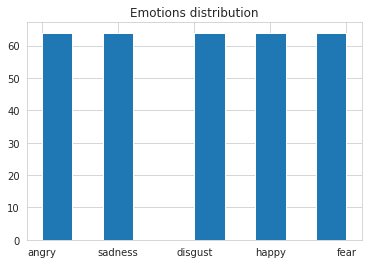

In [131]:
plt.title('Emotions distribution')
plt.hist(df_train['emotion_label'])
# plt.hist(y)
plt.show()

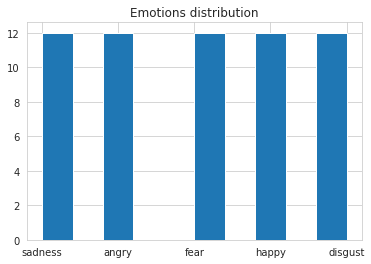

In [132]:
plt.title('Emotions distribution')
plt.hist(df_val['emotion_label'])
# plt.hist(y)
plt.show()

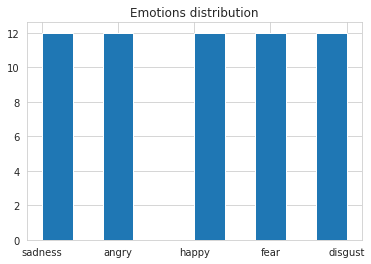

In [133]:
plt.title('Emotions distribution')
plt.hist(df_test['emotion_label'])
# plt.hist(y)
plt.show()

In [134]:
df_train.shape

(320, 4)

## Utils

In [135]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        X.append(librosa.load(i, res_type='kaiser_fast', sr=16000))
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new

# Data Augmentation 
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
def compute_mfccs(samples): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
        mfcc = mfcc.T
        mfcc = np.array(mfcc)
        mfccs.append(mfcc[:, 1:])
    mfccs = np.array(mfccs)
    return mfccs

def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=16000)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 16000)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
          mfcc = mfcc.T
          mfccs.append(mfcc[:, 1:])

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=16000, n_mfcc=13)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented[:, 1:])

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch[:, 1:])

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p[:, 1:]) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=16000, n_mfcc=13)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn[:, 1:]) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 


## Train

### Load samples and labels 

In [136]:
load_train = load_files(df_train)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 4417.67it/s]


In [137]:
samples_train = extract_samples(load_train)

In [138]:
labels_train = extract_labels(df_train)

### Decide length

In [139]:
lengths = compute_lengths(samples_train) 

In [140]:
new_lengths = check_outliers(lengths) 

0


In [141]:
mean_length = compute_mean_length(new_lengths)

In [142]:
mean_length

38324.953125

### Cut and Pad

In [143]:
samples_train, labels_train = cut_and_pad(samples_train, labels_train)

In [144]:
samples_train = np.array(samples_train)
labels_train = np.array(labels_train)
print(samples_train.shape, labels_train.shape)

(320,) (320,)


### Feature Extraction - Without Data Augmentation 

In [162]:
mfccs_train = compute_mfccs(samples_train)

100%|█████████████████████████████████████████| 320/320 [00:05<00:00, 59.18it/s]


In [163]:
mfccs_train.shape

(320, 248, 12)

## Val

### Load samples and labels

In [145]:
load_val = load_files(df_val)

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 3206.82it/s]


In [146]:
samples_val = extract_samples(load_val)

In [147]:
labels_val = extract_labels(df_val)

### Cut and Pad 

In [148]:
samples_val, labels_val = cut_and_pad(samples_val, labels_val)

In [149]:
samples_val = np.array(samples_val)
labels_val = np.array(labels_val)
print(samples_val.shape, labels_val.shape)

(60,) (60,)


### Feature Extraction

In [150]:
mfccs_val = compute_mfccs(samples_val)

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 64.55it/s]


In [151]:
mfccs_val.shape

(60, 248, 12)

## Test

### Load samples and labels

In [152]:
load_test = load_files(df_test)

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 2365.12it/s]


In [153]:
samples_test = extract_samples(load_test)

In [154]:
labels_test = extract_labels(df_test)

### Cut and Pad 

In [155]:
samples_test, labels_test = cut_and_pad(samples_test, labels_test)

In [156]:
samples_test = np.array(samples_test)
labels_test = np.array(labels_test)
print(samples_test.shape, labels_test.shape)

(60,) (60,)


### Feature Extraction

In [157]:
mfccs_test = compute_mfccs(samples_test)

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 61.42it/s]


In [158]:
mfccs_test.shape

(60, 248, 12)

# Encode Labels - Binary 

In [159]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [160]:
y_train = pd.Series(labels_train).replace(emotion_enc)
#y_train_aug = pd.Series(labels_train_aug).map(emotion_enc)
y_val = pd.Series(labels_val).map(emotion_enc)
y_test = pd.Series(labels_test).map(emotion_enc)

# Train, Val, Test (X) 

In [164]:
X_train = mfccs_train
#X_train_aug = mfccs_train_aug 
X_val = mfccs_val
X_test = mfccs_test 

# Standard Scaling 

## Without Augmentation

In [165]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Model 

In [66]:
model = Sequential()

model.add(layers.Conv1D(256, 7,padding='same',
                 input_shape=(248,12), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.6))

model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

2021-08-25 14:54:04.141551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-25 14:54:04.141878: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 248, 256)          21760     
_________________________________________________________________
activation (Activation)      (None, 248, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 62, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0

# Training

## Without Augmentation

### Load Data

In [67]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}



In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [69]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)

2021-08-25 14:54:23.723125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-25 14:54:23.741388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
80/80 [==============================] - 1s 9ms/step - loss: 6.5920 - accuracy: 0.6174 - val_loss: 0.9007 - val_accuracy: 0.7167
Epoch 2/500
80/80 [==============================] - 0s 6ms/step - loss: 1.7802 - accuracy: 0.6468 - val_loss: 0.6884 - val_accuracy: 0.5667
Epoch 3/500
80/80 [==============================] - 0s 6ms/step - loss: 1.5292 - accuracy: 0.6131 - val_loss: 0.4243 - val_accuracy: 0.7833
Epoch 4/500
80/80 [==============================] - 0s 5ms/step - loss: 1.1922 - accuracy: 0.6641 - val_loss: 0.4493 - val_accuracy: 0.8167
Epoch 5/500
80/80 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.7189 - val_loss: 0.4593 - val_accuracy: 0.8000
Epoch 6/500
80/80 [==============================] - 0s 5ms/step - loss: 0.7365 - accuracy: 0.7418 - val_loss: 0.4950 - val_accuracy: 0.7833
Epoch 7/500
80/80 [==============================] - 0s 6ms/step - loss: 0.5069 - accuracy: 0.7775 - val_loss: 0.4800 - val_accuracy: 0.8333
Epoch 8/500
8

### Plot Training Graphs

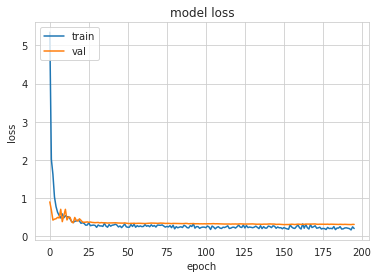

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

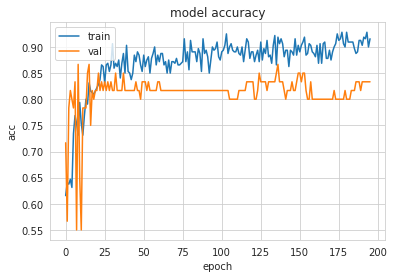

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model")

### Evaluate Model

In [ ]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model")

In [72]:
model.evaluate(X_test, y_test, batch_size=4)

15/15 [==============================] - 0s 2ms/step - loss: 0.3533 - accuracy: 0.8333


[0.353274941444397, 0.8333333134651184]

In [73]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.90      0.90      0.90        48

    accuracy                           0.83        60
   macro avg       0.74      0.74      0.74        60
weighted avg       0.83      0.83      0.83        60



# Hyperparameters optimization

## Initializer, Batch Size, Learning Rate 

In [166]:
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [167]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [168]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
#import tensorflow as tf 
#from tf.keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)
epochs = 50
batch_size = 4 
model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=KFold(3))
grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)

2021-08-30 16:26:29.707752: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 16:26:29.707960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-30 16:26:29.762280: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 16:26:29.762443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-30 16:26:29.818979: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
14/14 - 2s - loss: 0.8222 - accuracy: 0.5540
Epoch 1/50
14/14 - 2s - loss: 0.7910 - accuracy: 0.6056
Epoch 1/50
54/54 - 2s - loss: 0.7380 - accuracy: 0.5728
Epoch 1/50
14/14 - 3s - loss: 0.7551 - accuracy: 0.5654
Epoch 1/50
14/14 - 3s - loss: 0.9023 - accuracy: 0.5258
Epoch 2/50
14/14 - 2s - loss: 0.7337 - accuracy: 0.5399
Epoch 2/50
14/14 - 2s - loss: 0.8391 - accuracy: 0.4977
Epoch 1/50
54/54 - 3s - loss: 0.8436 - accuracy: 0.4626
Epoch 1/50
54/54 - 3s - loss: 0.7199 - accuracy: 0.4977
Epoch 2/50
54/54 - 2s - loss: 0.7004 - accuracy: 0.6056
Epoch 1/50
14/14 - 4s - loss: 1.0419 - accuracy: 0.5258
Epoch 2/50
14/14 - 2s - loss: 0.7901 - accuracy: 0.5514
Epoch 2/50
14/14 - 1s - loss: 0.7680 - accuracy: 0.6338
Epoch 3/50
14/14 - 2s - loss: 0.7661 - accuracy: 0.5869
Epoch 3/50
14/14 - 2s - loss: 0.8595 - accuracy: 0.6573
Epoch 2/50
54/54 - 2s - loss: 0.7007 - accuracy: 0.6355
Epoch 2/50
54/54 - 2s - loss: 0.6276 - accuracy: 0.7230
Epoch 2/50
14/14 - 2s - loss: 0.6063 - accuracy:

2021-08-30 16:31:54.721178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 16:31:54.721766: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-30 16:31:54.949222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-30 16:31:54.966176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/50
20/20 - 1s - loss: 0.8370 - accuracy: 0.5781
Epoch 2/50
20/20 - 0s - loss: 0.7007 - accuracy: 0.6906
Epoch 3/50
20/20 - 0s - loss: 0.5834 - accuracy: 0.6531
Epoch 4/50
20/20 - 0s - loss: 0.4804 - accuracy: 0.7781
Epoch 5/50
20/20 - 0s - loss: 0.4406 - accuracy: 0.7625
Epoch 6/50
20/20 - 0s - loss: 0.4984 - accuracy: 0.8094
Epoch 7/50
20/20 - 0s - loss: 0.4205 - accuracy: 0.7688
Epoch 8/50
20/20 - 0s - loss: 0.4831 - accuracy: 0.7375
Epoch 9/50
20/20 - 0s - loss: 0.4562 - accuracy: 0.7719
Epoch 10/50
20/20 - 0s - loss: 0.3969 - accuracy: 0.8000

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/50
20/20 - 0s - loss: 0.3395 - accuracy: 0.8344
Epoch 12/50
20/20 - 0s - loss: 0.2679 - accuracy: 0.8687
Epoch 13/50
20/20 - 0s - loss: 0.2634 - accuracy: 0.8813
Epoch 14/50
20/20 - 0s - loss: 0.2448 - accuracy: 0.8813
Epoch 15/50
20/20 - 0s - loss: 0.2728 - accuracy: 0.8813
Epoch 16/50
20/20 - 0s - loss: 0.1980 - accuracy: 0.9125
Epoch 17/50
20/2

In [170]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.790571908156077 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 16}
 mean=0.6468, std=0.0175 using {'lr': 5e-05, 'init_mode': 'glorot_uniform', 'batch_size': 16}
 mean=0.722, std=0.03534 using {'lr': 5e-05, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.7906, std=0.0126 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 16}
 mean=0.75, std=0.008324 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.7905, std=0.03578 using {'lr': 0.001, 'init_mode': 'glorot_uniform', 'batch_size': 8}
 mean=0.7282, std=0.01913 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.7749, std=0.02387 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.7875, std=0.003491 using {'lr': 0.001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.653, std=0.03627 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.6531, std=0.009033 using {'lr': 5e-05, 'init_mode': 'lecun_uniform', 'batch_si

## Train with best parameters

In [171]:
# Best Accuracy for 0.875 using {'lr': 0.001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
def create_model( init_mode='uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [172]:
seed = 7
np.random.seed(seed)

In [173]:
model = create_model()

In [174]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [175]:
import datetime, os

In [176]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [177]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-08-30 16:41:00.634773: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 16:41:00.634857: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 16:41:00.690918: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [178]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [179]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

Epoch 1/500
12/20 [=================>............] - ETA: 0s - loss: 1.3739 - accuracy: 0.5840

2021-08-30 16:41:02.293785: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-30 16:41:02.293809: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-30 16:41:02.309991: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-30 16:41:02.310877: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-30 16:41:02.312503: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-164100/train/plugins/profile/2021_08_30_16_41_02
2021-08-30 16:41:02.313324: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210830-164100/train/plugins/profile/2021_08_30_16_41_02/helemanc-Latitude-5410.trace.json.gz
2021-08-30 16:41:02.315462: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210830-164100/train/plugins/p

20/20 [==============================] - 1s 25ms/step - loss: 1.2857 - accuracy: 0.5831 - val_loss: 0.6420 - val_accuracy: 0.7333
Epoch 2/500
20/20 [==============================] - 0s 16ms/step - loss: 0.6533 - accuracy: 0.4594 - val_loss: 0.5067 - val_accuracy: 0.8167
Epoch 3/500
20/20 [==============================] - 0s 16ms/step - loss: 0.5779 - accuracy: 0.7090 - val_loss: 0.4466 - val_accuracy: 0.8000
Epoch 4/500
20/20 [==============================] - 0s 19ms/step - loss: 0.5547 - accuracy: 0.7058 - val_loss: 0.4282 - val_accuracy: 0.8333
Epoch 5/500
20/20 [==============================] - 0s 20ms/step - loss: 0.4417 - accuracy: 0.7775 - val_loss: 0.3811 - val_accuracy: 0.8500
Epoch 6/500
20/20 [==============================] - 0s 15ms/step - loss: 0.4585 - accuracy: 0.7629 - val_loss: 0.3447 - val_accuracy: 0.8500
Epoch 7/500
20/20 [==============================] - 0s 16ms/step - loss: 0.4975 - accuracy: 0.7818 - val_loss: 0.3924 - val_accuracy: 0.8667
Epoch 8/500
20/20 

In [180]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 31441), started 5:21:24 ago. (Use '!kill 31441' to kill it.)

In [181]:
model.evaluate(X_test, y_test, batch_size=8)

8/8 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 0.7833


[0.5822842121124268, 0.7833333611488342]

In [182]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.86      0.88      0.87        48

    accuracy                           0.78        60
   macro avg       0.66      0.65      0.65        60
weighted avg       0.78      0.78      0.78        60

